# 0.0. Helper Functions

In [1]:
# exploratory data analysis
import pandas                 as pd
import numpy                  as np
import seaborn                as sns
# import matplotlib             as plt
import matplotlib.pyplot      as plt
import scikitplot             as skplt

# jupyter settings
from IPython.core.display     import HTML

# data extraction
import pandas.io.sql          as psql
import psycopg2               as pg

from sqlalchemy               import create_engine, text
from sqlalchemy_utils         import database_exists, create_database

# useless
# from postgre_credentials import *

# import xgboost as xgb
from sklearn.preprocessing   import MinMaxScaler
from sklearn.linear_model    import LogisticRegression
from category_encoders.count import CountEncoder
from sklearn.model_selection import train_test_split
from sklearn                 import metrics as mt
from sklearn.neighbors       import KNeighborsClassifier
from category_encoders       import TargetEncoder
from sklearn.preprocessing   import RobustScaler
from sklearn.preprocessing   import StandardScaler

from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, cohen_kappa_score, label_ranking_average_precision_score
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV

In [2]:
def psycopg_connect():
    """"" Creates a psycopg connection from file postgre_credentials """""
    conn = pg.connect(    user = username,
                          password = pwd,
                          host = host,
                          port = port,
                          database = database)
    return conn

def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 12
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

def subplots_adjust():
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    return None


def metrics(y_test, y_predict,yhat_proba):

    accuracy_score  = mt.accuracy_score(y_test, y_predict)
    precision_score = mt.precision_score(y_test, y_predict, labels=1)
    recall_score    = mt.recall_score(y_test, y_predict)
    f1_score        = mt.f1_score(y_test, y_predict)

    print(f'Acurácia: {accuracy_score}')
    print(f'Precisão: {precision_score}')
    print(f'Recall:   {recall_score}')
    print(f'F1 Score: {f1_score}')

    skplt.metrics.plot_cumulative_gain(y_test, yhat_proba)
    
    return None

# 1.0 Loading Data

## 1.1 Database - Credentials & Connector 

In [3]:
# # Credentials
# host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# port = '5432'
# database = 'comunidadedsdb'
# username = 'member'
# pwd = 'cdspa'

# # Connector
# conn = pg.connect( user=username,
#                    password=pwd,
#                    host=host,
#                    port=port,
#                    database=database)

## 1.2 Data Collection - Tables and Schema Query

In [4]:
# # psycopg_connect()

# engine = create_engine('postgresql://'+username+':'+pwd+'@'+host+':'+port+'/'+database+'')

# with engine.begin() as conn: 
#     #select tables from schema
#     query_tables = "SELECT * FROM information_schema.tables WHERE table_schema = 'pa004'"
#     df_tables = pd.read_sql( text(query_tables) , conn )

#     # users
#     query_users = """SELECT * FROM pa004.users """
#     df_users = pd.read_sql( text(query_users) , conn )
    
#     # insurance
#     query_insurance = """SELECT * FROM pa004.insurance """
#     df_insurance = pd.read_sql( text(query_insurance) , conn )

#     # vehicle
#     query_vehicle = """SELECT * FROM pa004.vehicle """
#     df_vehicle = pd.read_sql( text(query_vehicle) , conn )

#     #build raw dataset:
#     query_raw = """
#     SELECT *
#     FROM pa004.users u 
#     INNER JOIN pa004.vehicle v on u.id = v.id 
#     INNER JOIN pa004.insurance i ON u.id = i.id
#     ORDER BY u.id
#     """
#     df_raw = pd.read_sql( text(query_raw) , conn )

## 1.3 Creating the main DataFrame - df_raw

In [5]:
# # creating df_raw
# df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
# df_raw.head()

In [6]:
# df_raw.to_csv('df_raw.csv', index=False)

In [7]:
df_raw = pd.read_csv('./dataset/df_raw.csv')

# 2.0 Data Description

In [8]:
df2 = df_raw.copy()

## 2.1 Rename Columns 

In [9]:
df2 = df2.rename(columns = {'vintage':'days_associated'})

## 2.2 Data Dimensions 

In [10]:
print(f'Linhas: {df2.shape[0]}')
print(f'Colunas: {df2.shape[1]}')

Linhas: 381109
Colunas: 12


## 2.3 Data Types

In [11]:
df2.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
days_associated           int64
response                  int64
dtype: object

## 2.4 Check NA

In [12]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
days_associated         0
response                0
dtype: int64

## 2.5 Fillout NA

In [13]:
# Não há nulos no dataset

## 2.6 Change types

In [14]:
# to object
df2['id'] = df2['id'].astype('object')

# to int
df2[['policy_sales_channel','region_code']] = df2[['policy_sales_channel','region_code']].astype('int64')

## 2.7 Descriptive Statistical

In [15]:
num_attributes = df2.select_dtypes( include= ['int64','float64'] )
cat_attributes = df2.select_dtypes( exclude= ['int64','float64', 'datetime64[ns]'] )

# Central Tendency - Mean, Median

ct1 = pd.DataFrame( num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min()  ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew()  ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis()  ) ).T

# concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-0.115266,-0.867857
2,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-0.900008,-0.970810
3,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-21.595182,464.354302
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,0.167747,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
6,days_associated,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688
7,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906,3.298788


# 3.0 Feature Engineering

In [16]:
df3 = df2.copy()

In [17]:
df3.sample(15)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,days_associated,response
123982,123983,Female,46,28,124,1,1-2 Year,Yes,0,39991.0,146,0
219607,219608,Female,50,28,154,1,> 2 Years,Yes,0,41247.0,109,0
240988,240989,Male,80,28,25,1,1-2 Year,Yes,0,35496.0,87,0
68926,68927,Male,44,28,109,1,1-2 Year,Yes,0,62047.0,132,0
179079,179080,Male,46,33,138,1,1-2 Year,Yes,0,38050.0,28,0
373380,373381,Male,54,50,25,1,1-2 Year,Yes,0,46985.0,28,0
318227,318228,Female,44,28,26,1,1-2 Year,Yes,0,43193.0,237,0
42907,42908,Male,38,41,156,1,1-2 Year,Yes,0,2630.0,171,0
82446,82447,Female,25,8,152,1,< 1 Year,No,1,31137.0,172,0
302479,302480,Female,59,40,26,1,1-2 Year,Yes,0,2630.0,27,0


## 3.1 Mapa Mental de Hipóteses

## 3.2 Feature Engineering


In [18]:
# changing the categories in 'vehicle_age' column
vehicle_age_dict = {'< 1 Year':'below_1_year', '1-2 Year':'between_1_2_years', '> 2 Years':'more_than_2_years'}
df3['vehicle_age'] = df3['vehicle_age'].map(vehicle_age_dict)

# 4.0 Filtragem de variáveis

In [19]:
# Rever a explicação do Meigarom sobre essa parte

In [20]:
df4 = df3.copy()

# 5.0 EDA - Exploratory Data Analysis

- Hipóteses sao mais propensas a adquirir o seguro saude:
- H1 - Mulheres
- H2 - Pessoas mais velhas 
- H3 - Pessoas com carros mais velhos 
- H4 - Pessoas com carros danificados 
- H5 - Pessoas previously_insured 
- H6 - Pessoas com maior 'annual_premium'
- H7 - Pessoas a mais tempos associadas

In [21]:
df5 = df4.copy()

## 5.1 Análise Univariada

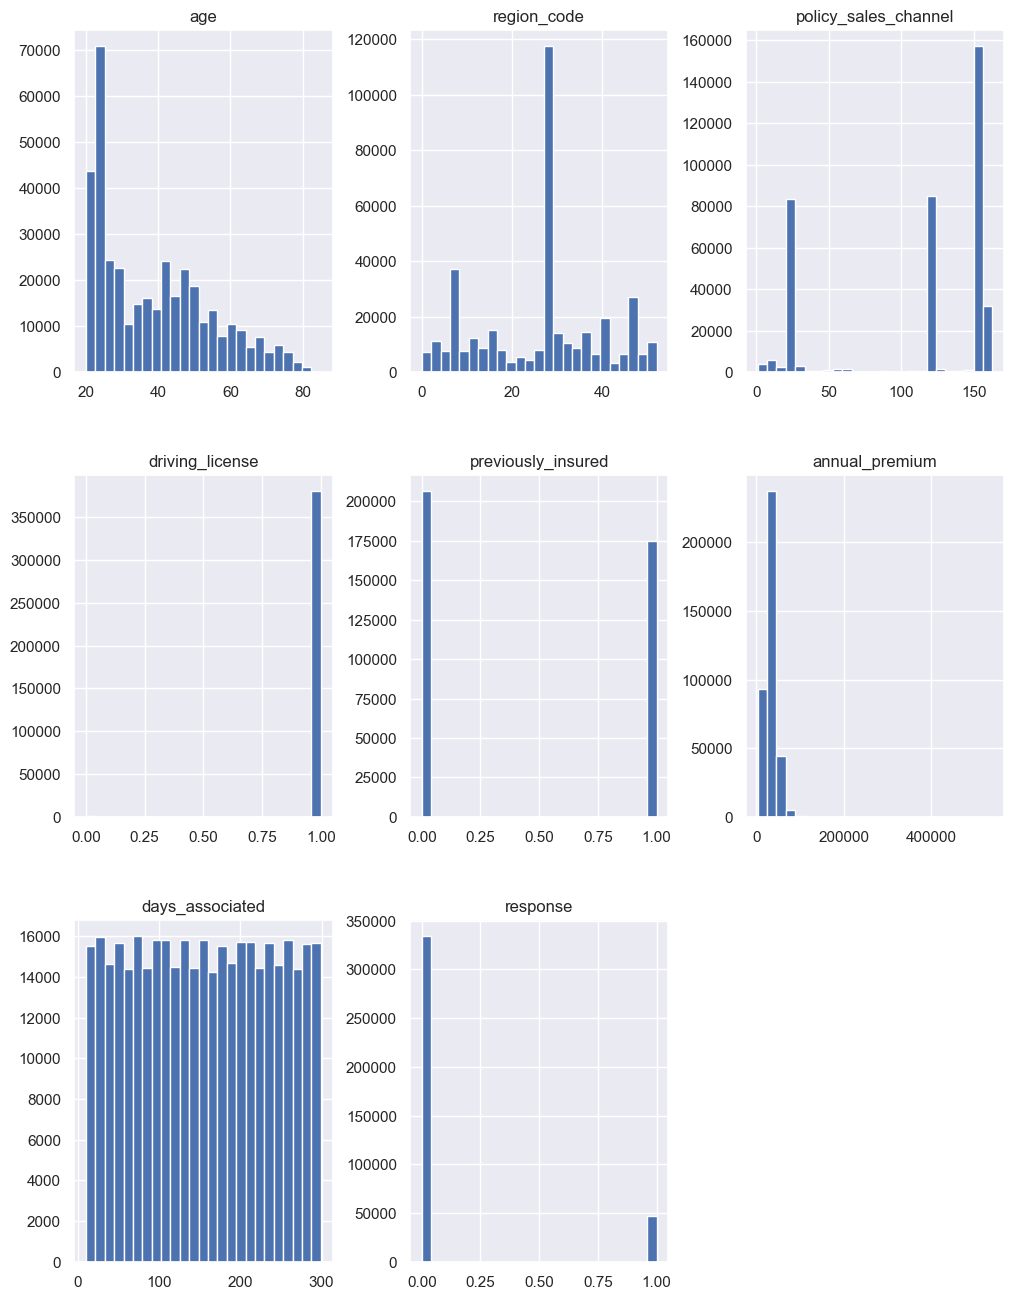

In [22]:
num_attributes.hist(bins=25, figsize=(12,16));

## 5.2 Análise Bivariada

### 5.1 - H1 - Mulheres sao mais propensas a adquirir o seguro saude

Falso. Homens são mais propensos que mulheres

In [23]:
aux = df5.loc[:, ['gender','response']].groupby(by=['gender']).agg({'gender':'count','response':'sum'})
aux.columns = ['total','positive']
aux = aux.reset_index()
aux['percentual'] = aux['positive']/aux['total']
aux

,gender,total,positive,percentual
0,Female,175020,18185,0.103902
1,Male,206089,28525,0.138411


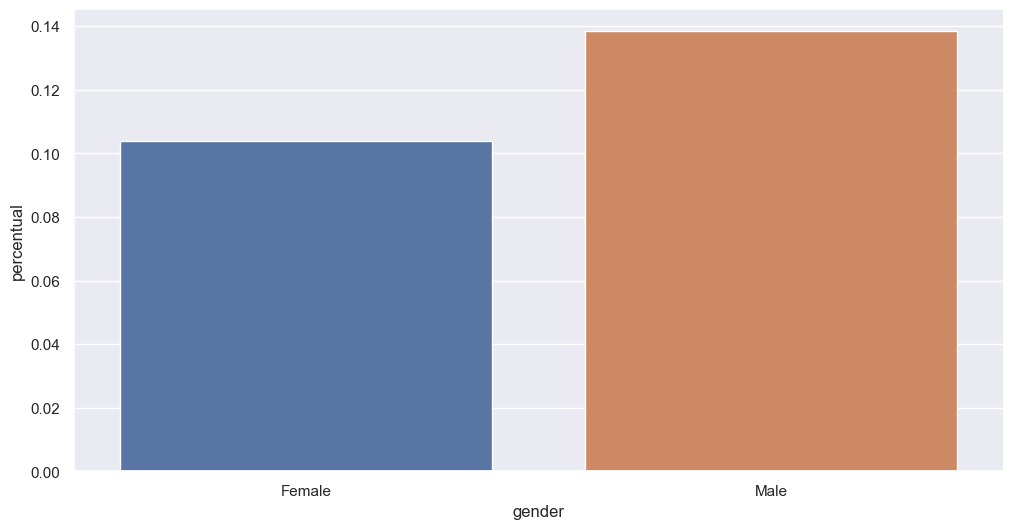

In [24]:
sns.barplot( x='gender',y='percentual', data = aux);

### 5.2 - H2 - Pessoas mais velhas sao mais propensas a adquirir o seguro saude

Falso. Pessoas de idade intermediaria são mais propensas a adquirir o seguro saude

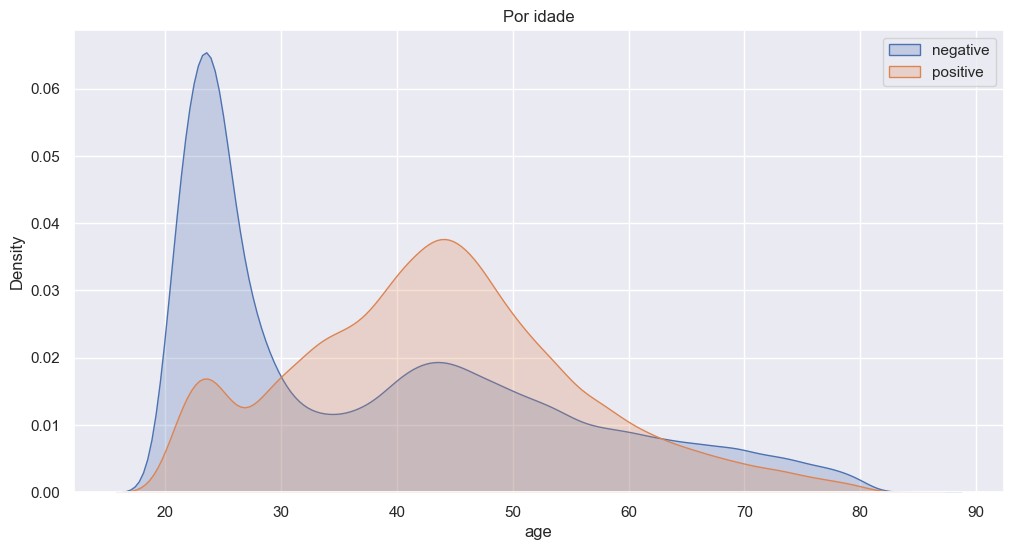

In [25]:
plt.subplot(1,1,1)
filter0 = (df5['response'] == 0)
filter1 = (df5['response'] == 1)

sns.kdeplot( df5.loc[filter0, 'age'], label='negative', fill=True )
sns.kdeplot( df5.loc[filter1, 'age'], label='positive', fill=True )
plt.legend()
plt.title('Por idade');

### 5.3 - H3 - Pessoas com carros mais velhos sao mais propensas a adquirir o seguro saude

Verdadeiro. Quanto mais velho o carro, mais propenso de adquirir o seguro saude.

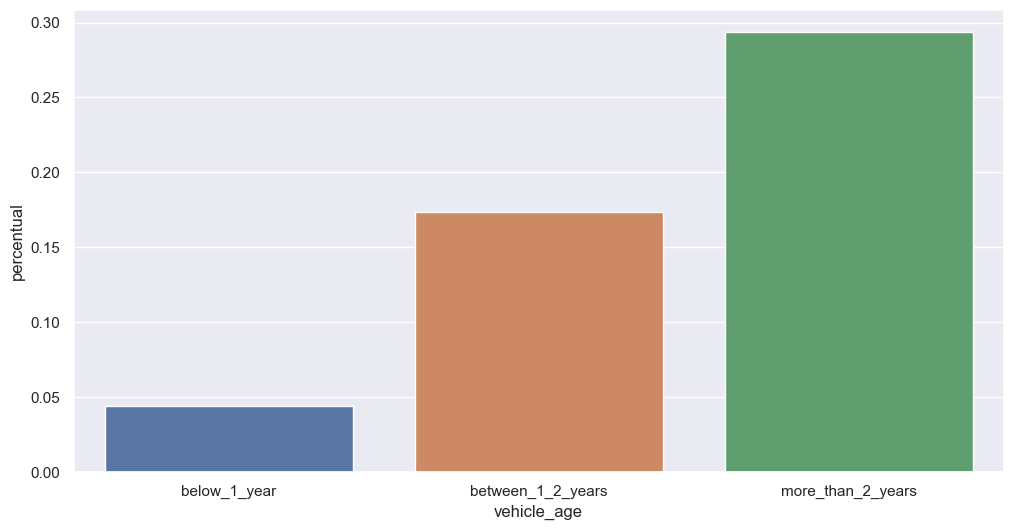

In [26]:
aux = df5.loc[:, ['vehicle_age','response']].groupby(by=['vehicle_age']).agg({'vehicle_age':'count','response':'sum'})
aux.columns = ['total','positive']
aux = aux.reset_index()
aux['percentual'] = aux['positive']/aux['total']

sns.barplot(data=aux, x='vehicle_age', y='percentual');

### 5.4 - H4 - Pessoas com carros danificados sao mais propensas a adquirir o seguro saude

Verdadeiro. Pessoas com carros danificados são mais propensas a adquirir o seguro saúde

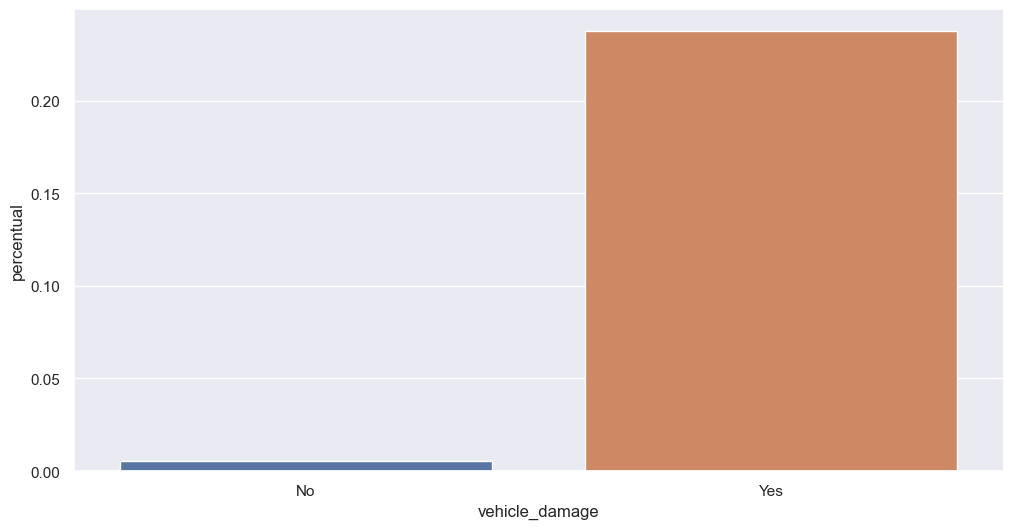

In [27]:
aux = df5.loc[:, ['vehicle_damage','response']].groupby(by=['vehicle_damage']).agg({'vehicle_damage':'count','response':'sum'})
aux.columns = ['total','positive']
aux = aux.reset_index()
aux['percentual'] = aux['positive']/aux['total']

sns.barplot(data=aux, x='vehicle_damage', y='percentual');

In [28]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,days_associated,response
0,1,Male,44,28,26,1,more_than_2_years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,between_1_2_years,No,0,33536.0,183,0
2,3,Male,47,28,26,1,more_than_2_years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,below_1_year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,below_1_year,No,1,27496.0,39,0


### 5.5 - H5 - Pessoas previamente asseguradas sao mais propensas a adquirir o seguro saude

Falso. Pessoas nunca asseguradas são as mais propensas a adquirir o seguro saude

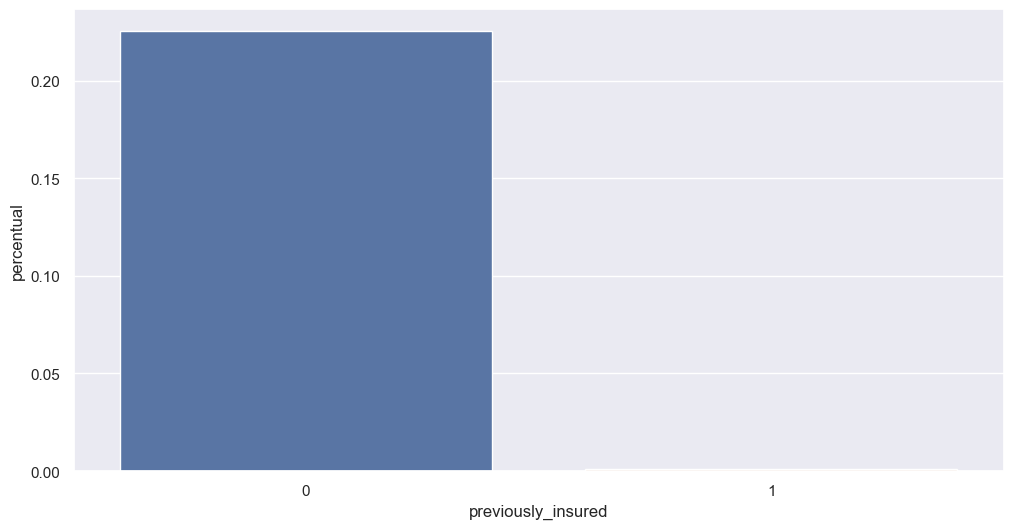

In [29]:
aux = df5.loc[:, ['previously_insured','response']].groupby(by=['previously_insured']).agg({'previously_insured':'count','response':'sum'})
aux.columns = ['total','positive']
aux = aux.reset_index()
aux['percentual'] = aux['positive']/aux['total']

sns.barplot(data=aux, x='previously_insured', y='percentual');

### 5.6 - H6 - Pessoas que ganham mais sao mais propensas a adquirir o seguro saude

Falso. Cancela da mesma maneira

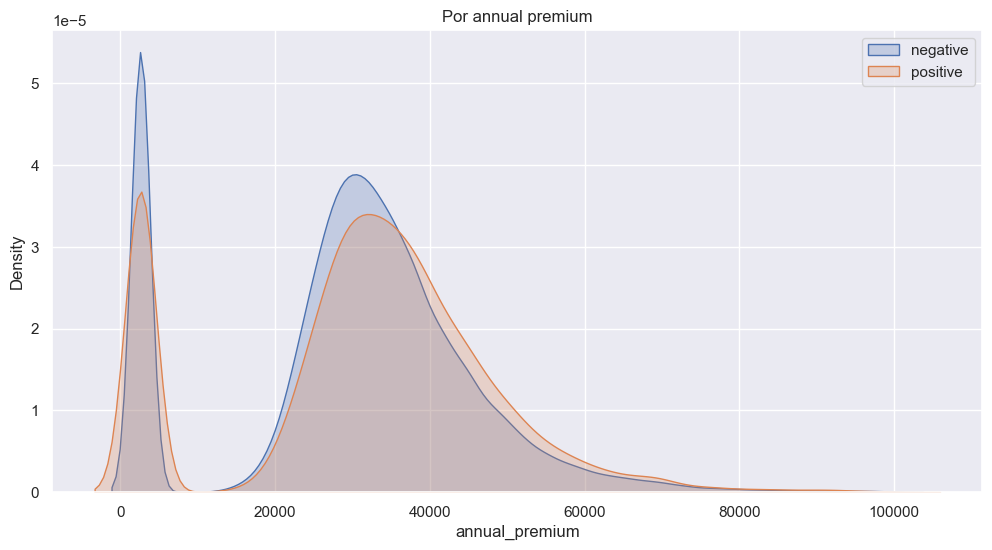

In [30]:
plt.subplot(1,1,1)
filter0 = (df5['response'] == 0) & (df5['annual_premium'] < 100000)
filter1 = (df5['response'] == 1) & (df5['annual_premium'] < 100000)

sns.kdeplot( df5.loc[filter0, 'annual_premium'], label='negative', fill=True )
sns.kdeplot( df5.loc[filter1, 'annual_premium'], label='positive', fill=True )
plt.legend()
plt.title('Por annual premium');

### 5.7 - H7 Pessoas a mais tempo associadas sao mais propensas a adquirir o seguro saude

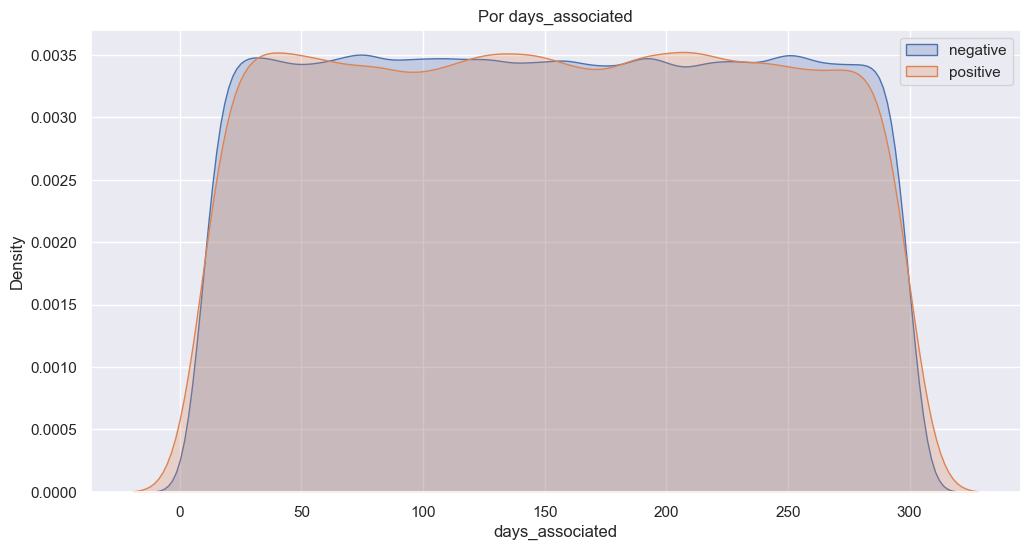

In [31]:
plt.subplot(1,1,1)
filter0 = (df5['response'] == 0)
filter1 = (df5['response'] == 1)

sns.kdeplot( df5.loc[filter0, 'days_associated'], label='negative', fill=True )
sns.kdeplot( df5.loc[filter1, 'days_associated'], label='positive', fill=True )
plt.legend()
plt.title('Por days_associated');

### 5.8 - H8 

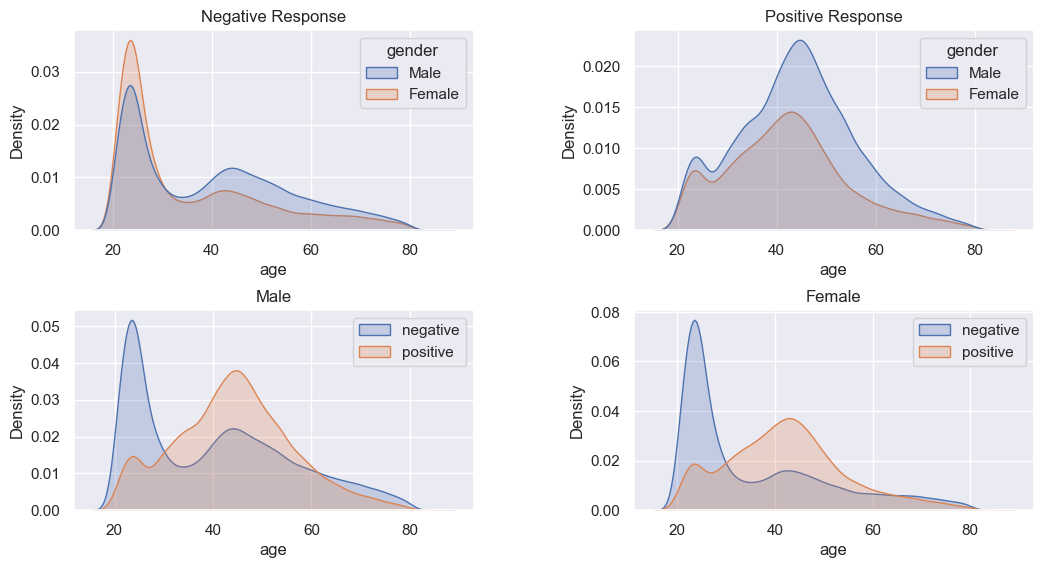

In [32]:
subplots_adjust()

plt.subplot(2,2,1)
sns.kdeplot( df5.loc[ df5['response'] == 0, ['gender', 'age']], x='age', hue='gender', fill=True, )
plt.title('Negative Response')

plt.subplot(2,2,2)
sns.kdeplot( df5.loc[ df5['response'] == 1, ['gender', 'age']], x='age', hue='gender', fill=True, )
plt.title('Positive Response')

plt.subplot(2,2,3)
filter0 = (df5['gender'] == 'Male') & (df5['response'] == 0)
filter1 = (df5['gender'] == 'Male') & (df5['response'] == 1)

sns.kdeplot( df5.loc[filter0, 'age'], label='negative', fill=True )
sns.kdeplot( df5.loc[filter1, 'age'], label='positive', fill=True )
plt.legend()
plt.title('Male')

plt.subplot(2,2,4)
filter0 = (df5['gender'] == 'Female') & (df5['response'] == 0)
filter1 = (df5['gender'] == 'Female') & (df5['response'] == 1)

sns.kdeplot( df5.loc[filter0, 'age'], label='negative', fill=True )
sns.kdeplot( df5.loc[filter1, 'age'], label='positive', fill=True )
plt.legend()
plt.title('Female');

## 5.3 Análise multivariada

### 5.3.1 Numerical Attributes


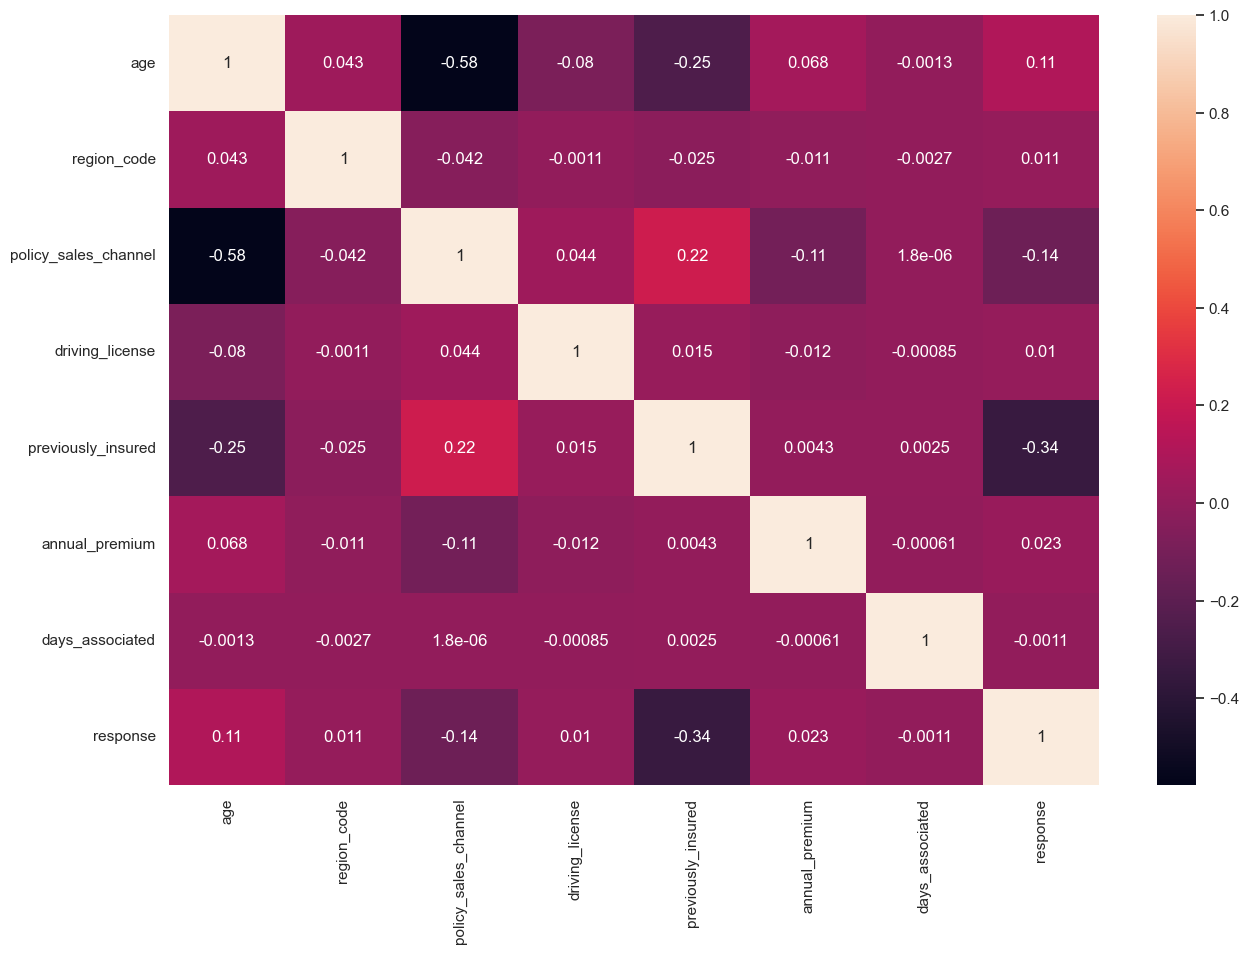

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))

correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 6.0 Data Preparation

In [34]:
df6 = df5.copy()

## 6.2 Transformação

In [35]:
df6

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,days_associated,response
0,1,Male,44,28,26,1,more_than_2_years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,between_1_2_years,No,0,33536.0,183,0
2,3,Male,47,28,26,1,more_than_2_years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,below_1_year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,below_1_year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26,26,1,between_1_2_years,No,1,30170.0,88,0
381105,381106,Male,30,37,152,1,below_1_year,No,1,40016.0,131,0
381106,381107,Male,21,30,160,1,below_1_year,No,1,35118.0,161,0
381107,381108,Female,68,14,124,1,more_than_2_years,Yes,0,44617.0,74,0


In [36]:
# One Hot Encoding
df6['vehicle_damage'] = df6['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)
df6['gender'] = df6['gender'].apply(lambda x: 1 if x=='Male' else 0)

# Target Encoding
vehicle_age_encoding = {'below_1_year':1, 'between_1_2_years':2, 'more_than_2_years':3}
df6['vehicle_age'] = df6['vehicle_age'].map(vehicle_age_encoding)

region_code_encoding = df6.groupby('region_code')['response'].mean()
df6['region_code'] = df6['region_code'].map(region_code_encoding)

policy_sales_channel_encoding = df6.groupby('policy_sales_channel')['response'].mean()
df6['policy_sales_channel'] = df6['policy_sales_channel'].map(policy_sales_channel_encoding)

In [37]:
# mms = MinMaxScaler()

# df6['annual_premium']       = mms.fit_transform(df6[['annual_premium']].values)
# df6['days_associated']      = mms.fit_transform(df6[['days_associated']].values)
# df6['age']                  = mms.fit_transform(df6[['age']].values)
# df6['policy_sales_channel'] = mms.fit_transform(df6[['policy_sales_channel']].values)
# df6['region_code']          = mms.fit_transform(df6[['region_code']].values)

In [38]:
ss = StandardScaler()

df6['annual_premium']       = ss.fit_transform(df6[['annual_premium']].values)
df6['days_associated']      = ss.fit_transform(df6[['days_associated']].values)
df6['age']                  = ss.fit_transform(df6[['age']].values)
df6['policy_sales_channel'] = ss.fit_transform(df6[['policy_sales_channel']].values)
df6['region_code']          = ss.fit_transform(df6[['region_code']].values)

In [39]:
df6

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,days_associated,response
0,1,1,0.333777,1.426484,0.889268,1,3,1,0,0.574539,0.748795,1
1,2,1,2.396751,0.112584,0.889268,1,2,0,0,0.172636,0.342443,0
2,3,1,0.527181,1.426484,0.889268,1,3,1,0,0.449053,-1.521998,1
3,4,1,-1.148985,-0.216476,-1.087420,1,1,0,1,-0.113018,0.581474,0
4,5,0,-0.633242,-0.017380,-1.087420,1,1,0,1,-0.178259,-1.378580,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,2.267815,-1.110246,0.889268,1,2,0,1,-0.022912,-0.792954,0
381105,381106,1,-0.568774,-0.956251,-1.087420,1,1,0,1,0.549093,-0.279037,0
381106,381107,1,-1.148985,-1.076230,-1.166292,1,1,0,1,0.264543,0.079509,0
381107,381108,0,1.881007,-0.714430,0.770764,1,3,1,0,0.816389,-0.960275,0


# 7.0 Feature Selection

In [40]:
df7 = df6.copy()

# 8.0. Machine Learning Model

Acurácia: 0.8761204055500745
Precisão: 0.4020618556701031
Recall:   0.0066298342541436465
F1 Score: 0.01304456894389163


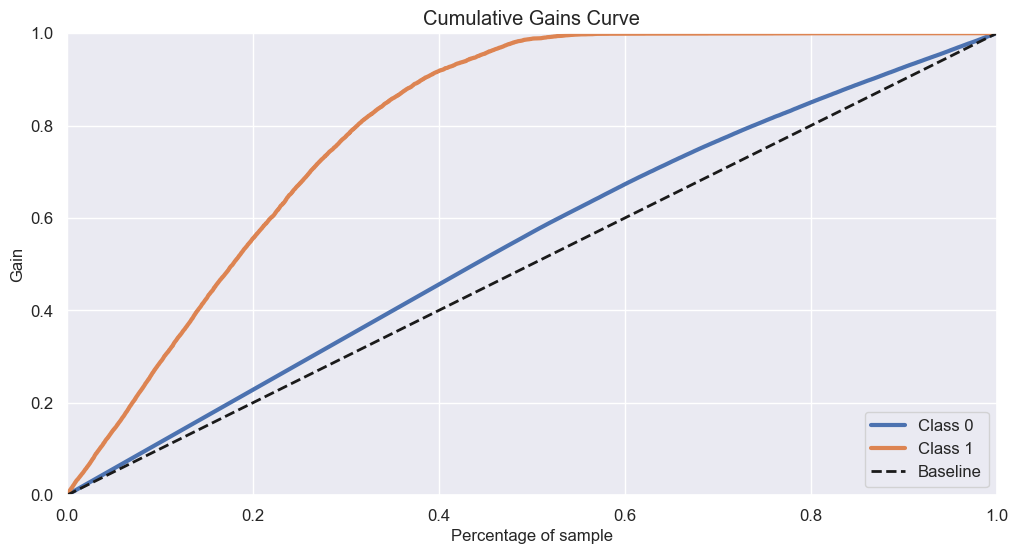

In [41]:
df8 = df6.copy()
X = df8.drop(columns=['id','response'])
y = df8['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression( max_iter=1000 )

lr.fit(X_train, y_train)

y_predict = lr.predict( X_test )
yhat_proba = lr.predict_proba( X_test )

metrics(y_test,y_predict, yhat_proba)

Acurácia: 0.8761204055500745
Precisão: 0.4020618556701031
Recall:   0.0066298342541436465
F1 Score: 0.01304456894389163


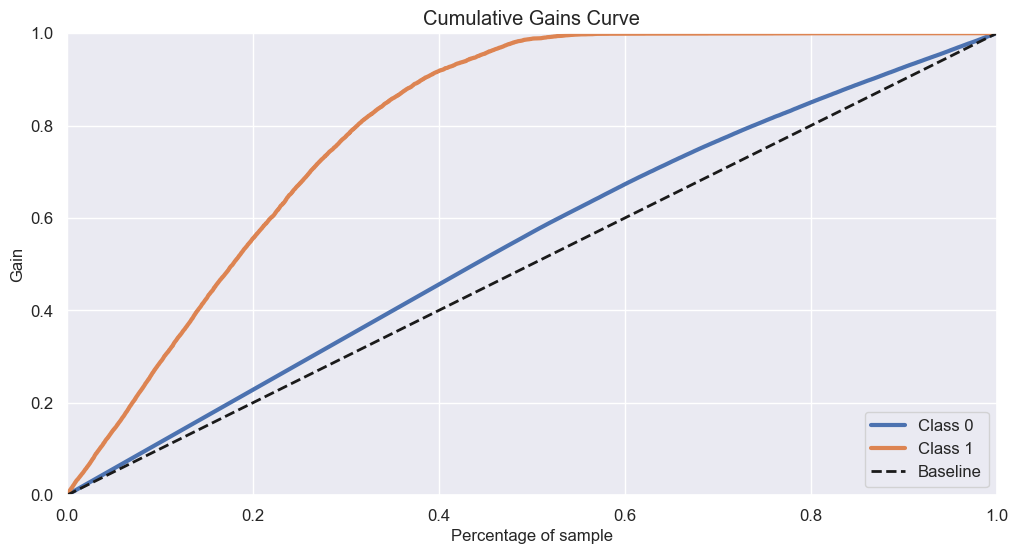

In [42]:
df8 = df6.copy()
X = df8.drop(columns=['id','response'])
y = df8['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression( max_iter=1000 )

lr.fit(X_train, y_train)

y_predict = lr.predict( X_test )
yhat_proba = lr.predict_proba( X_test )

metrics(y_test,y_predict, yhat_proba)

Acurácia: 0.8761204055500745
Precisão: 0.4020618556701031
Recall:   0.0066298342541436465
F1 Score: 0.01304456894389163


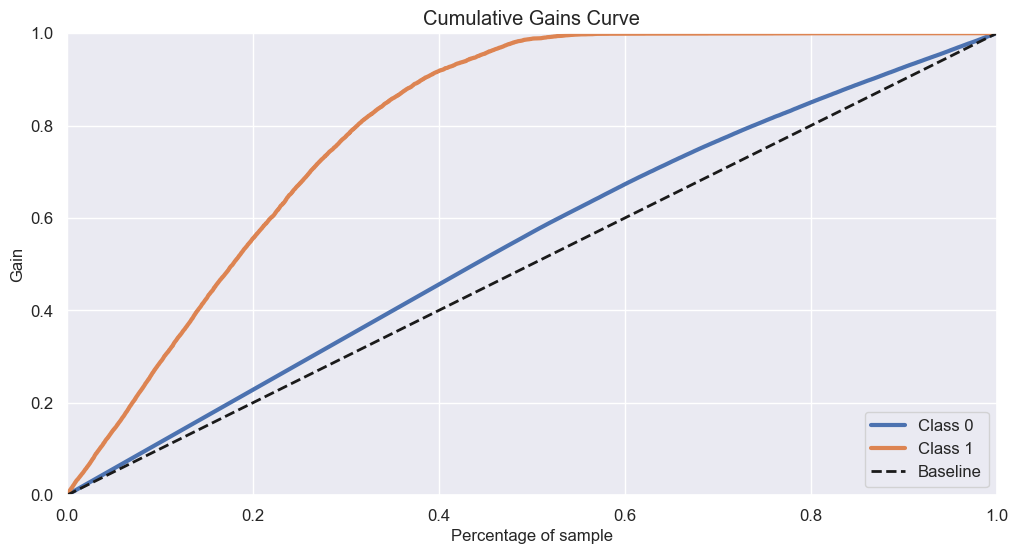

In [43]:
df8 = df6.copy()
X = df8.drop(columns=['id','response'])
y = df8['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression( max_iter=1000 )

lr.fit(X_train, y_train)

y_predict = lr.predict( X_test )
yhat_proba = lr.predict_proba( X_test )

metrics(y_test,y_predict, yhat_proba)

Acurácia: 0.8761204055500745
Precisão: 0.4020618556701031
Recall:   0.0066298342541436465
F1 Score: 0.01304456894389163


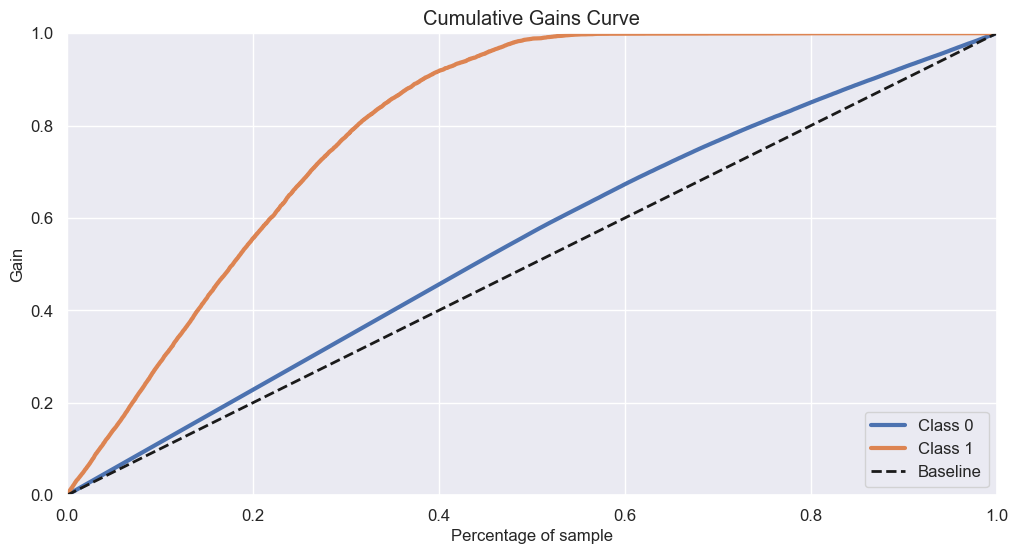

In [44]:
df8 = df6.copy()
X = df8.drop(columns=['id','response'])
y = df8['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression( max_iter=1000 )

lr.fit(X_train, y_train)

y_predict = lr.predict( X_test )
yhat_proba = lr.predict_proba( X_test )

metrics(y_test,y_predict, yhat_proba)

Acurácia: 0.8761204055500745
Precisão: 0.4020618556701031
Recall:   0.0066298342541436465
F1 Score: 0.01304456894389163


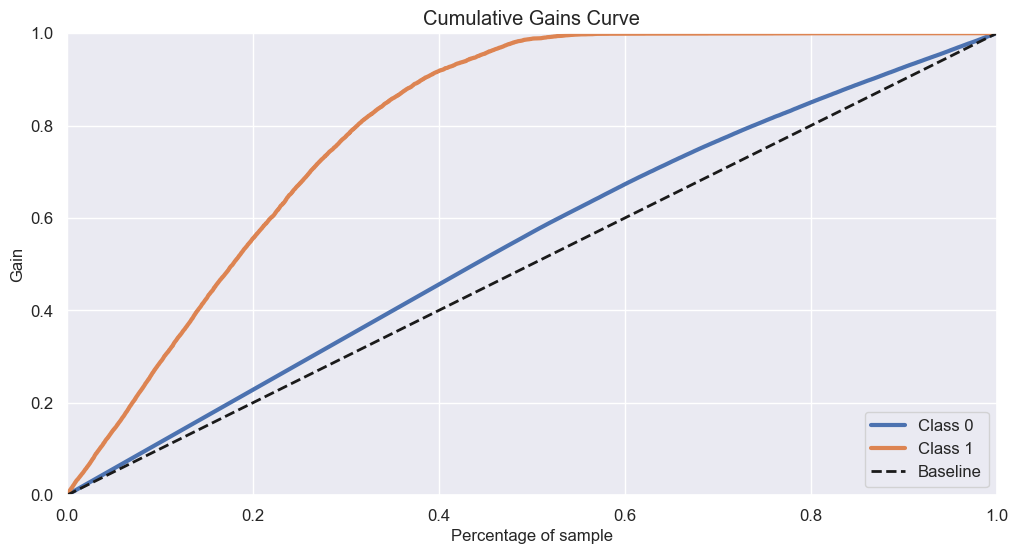

In [45]:
df8 = df6.copy()
X = df8.drop(columns=['id','response'])
y = df8['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression( max_iter=1000 )

lr.fit(X_train, y_train)

y_predict = lr.predict( X_test )
yhat_proba = lr.predict_proba( X_test )

metrics(y_test,y_predict, yhat_proba)

Acurácia: 0.8761204055500745
Precisão: 0.4020618556701031
Recall:   0.0066298342541436465
F1 Score: 0.01304456894389163


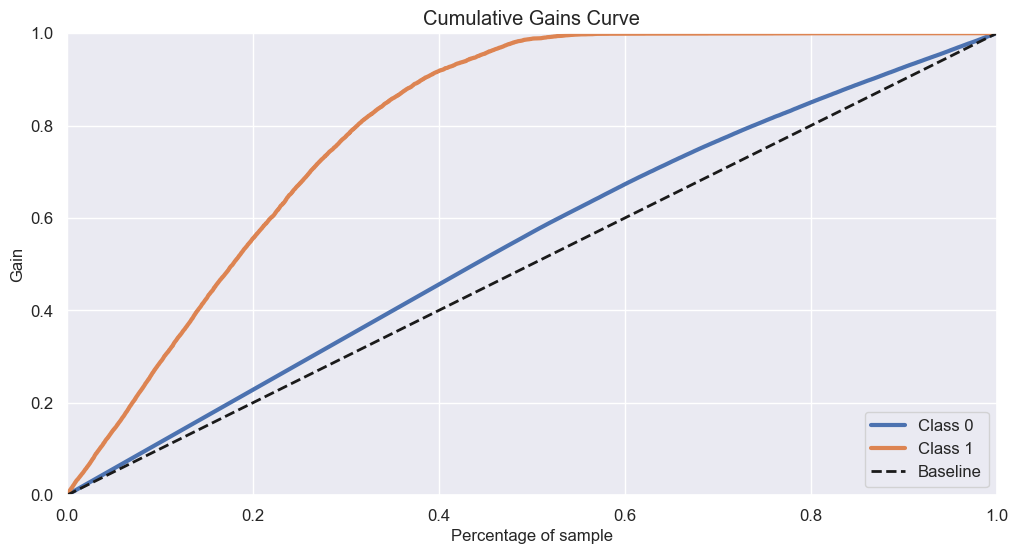

In [46]:
df8 = df6.copy()
X = df8.drop(columns=['id','response'])
y = df8['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression( max_iter=1000 )

lr.fit(X_train, y_train)

y_predict = lr.predict( X_test )
yhat_proba = lr.predict_proba( X_test )

metrics(y_test,y_predict, yhat_proba)

Acurácia: 0.8760889187430466
Precisão: 0.39487179487179486
Recall:   0.006544836379090523
F1 Score: 0.012876254180602006


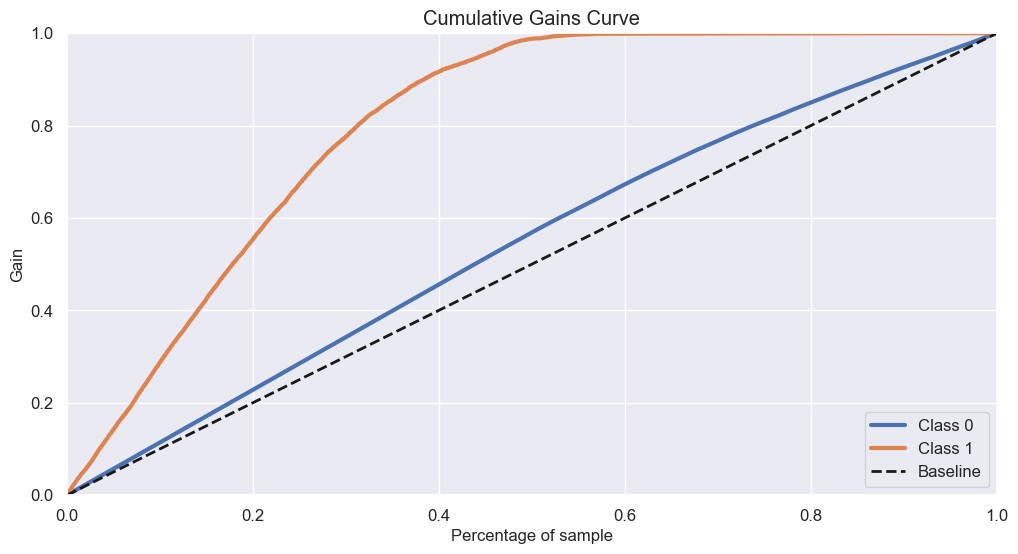

In [47]:
df8 = df6.copy()
X = df8.drop(columns=['id','response','gender','driving_license'])
y = df8['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression( max_iter=1000 )

lr.fit(X_train, y_train)

y_predict = lr.predict( X_test )
yhat_proba = lr.predict_proba( X_test )

metrics(y_test,y_predict, yhat_proba)

In [52]:
from sklearn import ensemble        as en

In [53]:
# model definition
extra_trees = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

In [54]:
# data preparation
x_train_n = X_train # (274398 rows × 12 columns)
y_train_n = y_train.values #(274398 rows)
extra_trees.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                feature  importance
0       days_associated    0.271107
0        annual_premium    0.248898
0                   age    0.149377
0           region_code    0.095783
0  policy_sales_channel    0.090441
0        vehicle_damage    0.064301
0    previously_insured    0.063312
0           vehicle_age    0.016780


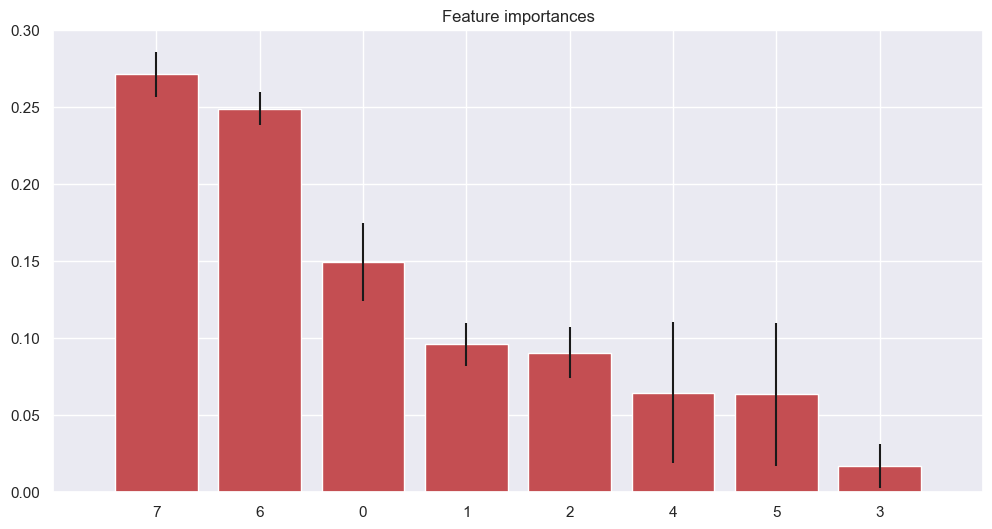

In [56]:
importances = extra_trees.feature_importances_
std = np.std( [tree.feature_importances_ for tree in extra_trees.estimators_], axis=0 )
indices = np.argsort(importances)[::-1] #trees importance ordered by greater value

# Print feature ranking
print('Feature Ranking:')
df_imp = pd.DataFrame()
for i, j in zip( x_train_n, extra_trees.feature_importances_ ):
    aux = pd.DataFrame( {'feature':i , 'importance': j}, index=[0] )
    df_imp = pd.concat( [df_imp, aux], axis=0 )
    
print(df_imp.sort_values('importance', ascending=False) )

# Plot the imputity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_n.shape[1]), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

# 9.0 Deployment

In [ ]:
class HealthInsurance:
    def __init__( self ):
        self.home_path=''
        self.home=''
        
    def data_cleaning( df2 ):
    
    df2 = df2.rename(columns = {'vintage':'days_associated'})
    
    return df2

    def feature_engineering( df3 ):
        # changing the categories in 'vehicle_age' column
        vehicle_age_dict = {'< 1 Year':'below_1_year', '1-2 Year':'between_1_2_years', '> 2 Years':'more_than_2_years'}
        df3['vehicle_age'] = df3['vehicle_age'].map(vehicle_age_dict)
        
        return df3

    def data_preparation( df4 ):
        
        return df4